# Filtering and trimming messages

## Messages as state

In [4]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


In [5]:
from dotenv import load_dotenv
load_dotenv("C:\\Users\\praka\\Documents\\ML Hands-on\\.env")

True

In [6]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="llama-3.3-70b-versatile")
llm.invoke(messages)

AIMessage(content="Besides whales, there are many other fascinating ocean mammals. Here are a few examples:\n\n1. **Dolphins**: Highly intelligent and social animals, dolphins are known for their playful behavior and complex communication skills.\n2. **Seals and Sea Lions**: These pinnipeds (fin-footed mammals) are adapted to life in the water, with flippers and streamlined bodies. They're found in oceans around the world and are popular attractions at zoos and aquariums.\n3. **Walruses**: Large, tusky mammals that inhabit the Arctic and sub-Arctic oceans. They're known for their distinctive whiskers and ability to dive to great depths in search of food.\n4. **Manatees**: Also known as sea cows, manatees are large, gentle herbivores that inhabit shallow, coastal waters in the Caribbean and Gulf of Mexico.\n5. **Dugongs**: Similar to manatees, dugongs are large marine mammals that feed on seagrass and other aquatic plants. They're found in shallow waters in the Pacific and Indian Oceans

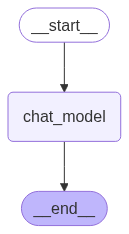

In [7]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Besides whales, there are several other fascinating ocean mammals you might want to learn about. Here are a few:

1. **Dolphins**: Highly intelligent and social creatures, dolphins are closely related to whales and porpoises. They're known for their playful behavior and complex communication patterns.
2. **Seals and Sea Lions**: These pinnipeds (fin-footed mammals) are adapted to life in the water, with flippers, streamlined bodies, and a layer of blubber to keep warm. They're found in oceans around the world, from the Arctic to the Antarctic.
3. **Walruses**: Large, tusked mammals that inhabit the Arctic and sub

## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

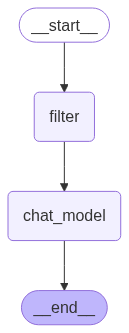

In [29]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

There are many other fascinating ocean mammals beyond whales. Here are a few examples:

1. **Dolphins**: Highly intelligent and social creatures, dolphins are known for their playful behavior and ability to communicate with each other using clicks and whistles.
2. **Seals and Sea Lions**: These pinnipeds (fin-footed mammals) are adapted to life in the water, with flippers and a streamlined body. They're found in oceans aro

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

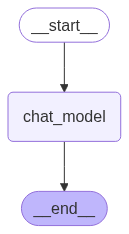

In [10]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [12]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

There are many other fascinating ocean mammals beyond whales. Here are a few examples:

1. **Dolphins**: Highly intelligent and social creatures, dolphins are known for their playful behavior and ability to communicate with each other using clicks and whistles.
2. **Seals and Sea Lions**: These pinnipeds (fin-footed mammals) are adapted to life in the water, with flippers and a streamlined body. They're found in oceans aro

In [13]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

There are many other fascinating ocean mammals beyond whales. Here are a few examples:

1. **Dolphins**: Highly intelligent and social creatures, dolphins are known for their playful behavior and ability to communicate with each other using clicks and whistles.
2. **Seals and Sea Lions**: These pinnipeds (fin-footed mammals) are adapted to life in the water, with flippers and a streamlined body. They're found in oceans aro

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

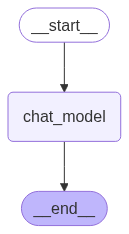

In [14]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatGroq(model="llama-3.3-70b-versatile"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

There are many other fascinating ocean mammals beyond whales. Here are a few examples:

1. **Dolphins**: Highly intelligent and social creatures, dolphins are known for their playful behavior and ability to communicate with each other using clicks and whistles.
2. **Seals and Sea Lions**: These pinnipeds (fin-footed mammals) are adapted to life in the water, with flippers and a streamlined body. They're found in oceans aro

In [16]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatGroq(model="llama-3.3-70b-versatile"),
            allow_partial=False
        )

ImportError: Could not import transformers python package. This is needed in order to calculate get_token_ids. Please install it with `pip install transformers`.

In [ ]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages})

In [ ]:
for m in messages_out_trim['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several fascinating ocean mammals worth learning about. Here are a few:

1. **Dolphins**: Highly intelligent and social creatures, dolphins are known for their playful behavior and complex communication skills. They are found in oceans all around the world.

2. **Porpoises**: Similar to dolphins but generally smaller, porpoises are also highly intelligent and social. They are found in coast